<a href="https://colab.research.google.com/github/Hubert26/machine-learning/blob/data-exp/project_hubert_szewczyk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPIS PROJEKTU

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z
inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują
pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną
kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie.
Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club
opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach
udzielonych za pośrednictwem swojej platformy w określonych okresach.
Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za
pośrednictwem Lending Club na przestrzeni lat 2007 -2011. Każda pożyczka jest opatrzona
informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie
loan_status).

W tym projekcie chcę zbudować model klasyfikacyjny, który na podstawie zebranych danych będzie przewidywał, czy potencjalny pozyczkobiorca spłaci swój dług.

#KOD

##Import bibliotek i ustawienia

In [49]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

#!pip install -q --upgrade plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
print(plotly.__version__)

5.15.0


##Definicje funkcji

In [4]:
def display_info(df, selected_columns, df_info):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:
        print("Column Name:", col_name)

        # Description
        if col_name in df_info.index:
            print("Description:", df_info.loc[col_name]['Description'])
        else:
            print("Description not available.")

        # Statistics
        print("\nStatistics:")
        print(df[col_name].describe())

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns

In [5]:
def nan_counts(df, min_nan, max_nan):
    mask = df.isna()
    nan_counts_columns = mask.sum()
    naan_column = pd.DataFrame(nan_counts_columns, columns=['NaN'])
    selected_columns = [col_name for col_name in naan_column.index if min_nan <= naan_column.at[col_name, 'NaN'] <= max_nan]

    #display(naan_column.loc[:])
    return selected_columns

In [6]:
def unique_counts(df, min_unique=0, max_unique=None):

    unique_counts_columns = df.nunique()
    unique_column = pd.DataFrame(unique_counts_columns, columns=['Unique'])
    selected_columns = [col_name for col_name, unique_count in unique_column.iterrows()
                        if min_unique <= unique_count['Unique'] and (max_unique is None or unique_count['Unique'] <= max_unique)]

    return selected_columns

In [7]:
def diff_counts(df, min_diff, max_diff):
  unique_value_counts = {}
  for col_name in df.columns.tolist():
      unique_value_counts[col_name] = df[col_name].value_counts()

  #Obliczenie różnicy między liczbami wystąpień unikalnych wartości w kolumnach
  value_count_differences = pd.DataFrame(index=df.columns.tolist(), columns=['diff'])
  for col_name, counts in unique_value_counts.items():
  # Sortowanie wartości występujących w danej kolumnie malejąco
      sorted_counts = counts.sort_values(ascending=False)

      # Sprawdzanie, czy są przynajmniej dwie różne wartości
      if len(sorted_counts) >= 2:
          diff = sorted_counts.iloc[0] - sorted_counts.iloc[1]
          value_count_differences.at[col_name, 'diff'] = diff
      else:
          value_count_differences.at[col_name, 'diff'] = 0  # Jeśli jest mniej niż dwie różne wartości, to różnica wynosi 0

  selected_columns = value_count_differences.index[
      (value_count_differences['diff'] >= min_diff) &
       (value_count_differences['diff'] <= max_diff)].tolist()
  return selected_columns


##1. Obróbka danych

###Pobranie danych z plików

In [8]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/Loan_data.csv', low_memory=False)

In [9]:
df = df_raw.copy()

In [10]:
df_info_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/LCDataDictionary.csv')

In [11]:
df_info = df_info_raw.iloc[:, 0:2]
df_info.set_index(df_info.columns.tolist()[0], inplace=True)

###Eksploracja danych

In [12]:
df.shape

(42536, 151)

In [13]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,Jan-2015,171.62,NaN,Aug-2018,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


In [15]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42535.000000,42535.000000,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42506.000000,42535.0,42535.0,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42390.0,0.0,42535.0,0.0,0.0,0.0,42506.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42390.0,42506.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41170.000000,42430.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.000000,160.000000,160.000000
mean,NaN,11089.722581,10821.585753,10139.938785,322.623063,6.913656e+04,13.373043,0.152449,713.052545,717.052545,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,22.124406,0.0,0.0,12020.189644,11312.729377,9675.675936,2239.981444,1.516890,103.015467,14.387843,2613.245652,689.922511,676.952039,0.0,NaN,1.0,NaN,NaN,NaN,0.000094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.143039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045227,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4272.137875,49.905875,1.200000
std,NaN,7410.938391,7146.914675,7131.598014,208.927216,6.409635e+04,6.726315,0.512406,36.188439,36.188439,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,11.592811,0.0,0.0,9094.685888,9038.506549,7105.750304,2585.057393,7.830064,735.799086,162.177837,4385.066535,80.818099,119.647752,0.0,NaN,0.0,NaN,NaN,NaN,0.009700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,29.359579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [16]:
#Sprawdzenie czy wszystkie wartości są unikalne
len(df['id'].unique())==df.shape[0]

True

In [17]:
column_names = df.columns.tolist()

In [18]:
df_info

,Description
LoanStatNew,
acc_now_delinq,The number of accounts on which the borrower i...
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan...
all_util,Balance to credit limit on all trades
annual_inc,The self-reported annual income provided by th...
...,...
settlement_amount,The loan amount that the borrower has agreed t...
settlement_percentage,The settlement amount as a percentage of the p...
settlement_term,The number of months that the borrower will be...


###Wyświetlenie Loan Status

Charged Off to status długu uznawanego za nieściągalny po 180 dniach braku płatności, ale nie oznacza umorzenia długu. Odpisanie długu wpływa negatywnie na historię kredytową i zdolność kredytową pożyczkobiorcy. Mimo spłaty długu, status Charged Off pozostaje w raporcie kredytowym przez siedem lat, choć może zostać zmieniony na "odpis opłacony" lub "odpis rozliczony". W praktyce, wiele osób spłaciło dług, ale nadal ma status Charged Off.

In [19]:
df_info.loc["settlement_status"]['Description']

'The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT'

In [20]:
df.settlement_status.unique()

array([nan, 'COMPLETE', 'BROKEN', 'ACTIVE'], dtype=object)

In [21]:
df_info.loc["loan_status"]['Description']

'Current status of the loan'

In [22]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [23]:
df["loan_status"] = df["loan_status"].replace(
    {"Does not meet the credit policy. Status:Fully Paid": "Fully Paid",
     "Does not meet the credit policy. Status:Charged Off": "Charged Off"})

In [24]:
df[(df.loan_status == 'Charged Off') & (df.settlement_status == "COMPLETE")].shape[0]

142

Wynika z tego, że są 142 wyniki z loan_status == Charged Off wraz z settlement_status == COMPLETE.

W dalszej części zmieniamy wynik Charged Off na Fully Paid dla takich wpisów.

In [25]:
df.loc[df['settlement_status'] == "COMPLETE", 'loan_status'] = "Fully Paid"

In [26]:
df['loan_status'].value_counts()

Fully Paid     36246
Charged Off     6289
Name: loan_status, dtype: int64

###Usunięcie kolumn które zawierają informacje z przyszłości, niedostępne w momencie udzielania pożyczki

In [27]:
future_data = df[["mths_since_last_delinq", "last_pymnt_d",
                      "collection_recovery_fee", "recoveries", "issue_d",
                      "total_rec_late_fee", "total_rec_prncp", "funded_amnt",
                      "funded_amnt_inv", "last_fico_range_high",
                      "last_fico_range_low", "debt_settlement_flag"]]
selected_columns = future_data.columns
df.drop(columns=selected_columns, inplace=True, axis=1, errors='ignore')

###Usunięcie kolumn ze zbędnymi informacjami

####Usunięcie kolumn które mają ponad 90% wartości NaN

In [28]:
selected_columns = nan_counts(df,0.9*df.shape[0], df.shape[0])
df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

####Usunięcie kolumn o: jednej unikalnej wartości, ilości NaN < 1/4 ilości wierszy

In [29]:
selected_columns = list(set(unique_counts(df, 0, 1)) &
                        set(nan_counts(df, 0, 0.25*df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))
display_info(df, selected_columns, df_info)

df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

['policy_code', 'chargeoff_within_12_mths', 'out_prncp_inv', 'initial_list_status', 'disbursement_method', 'pymnt_plan', 'out_prncp', 'collections_12_mths_ex_med', 'hardship_flag', 'application_type']
10
Column Name: policy_code
Description: publicly available policy_code=1
new products not publicly available policy_code=2

Statistics:
count    42535.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: policy_code, dtype: float64

Mode:
0    1.0
Name: policy_code, dtype: float64

NaN count: 1

Unique values len:
2

Unique values:
[ 1. nan]

Value counts:
1.0    42535
Name: policy_code, dtype: int64

Column Name: chargeoff_within_12_mths
Description: Number of charge-offs within 12 months

Statistics:
count    42390.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: chargeoff_within_12_mths, dtype: float64

Mode:
0    0.0
Name: chargeoff_w

###Analiza brakujących wartości wraz z ich uzupełnieniem/usunięciem przy wzięciu pod uwagę pewnych ustalonych kryteriów

####Usunięcie kolumn o: dużej ilości unikalnych wartości, typu != float64

In [30]:
selected_columns = list(set(unique_counts(df, 0.1*df.shape[0], df.shape[0])) &
                        set(nan_counts(df, 0, df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0]))&
                        set([col for col in df.columns if df[col].dtype != 'float64']))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

['url', 'emp_title', 'title', 'desc', 'id']
5
Column Name: url
Description: URL for the LC page with listing data.

Statistics:
count                                                 42535
unique                                                42535
top       https://lendingclub.com/browse/loanDetail.acti...
freq                                                      1
Name: url, dtype: object

Mode:
0        https://lendingclub.com/browse/loanDetail.acti...
1        https://lendingclub.com/browse/loanDetail.acti...
2        https://lendingclub.com/browse/loanDetail.acti...
3        https://lendingclub.com/browse/loanDetail.acti...
4        https://lendingclub.com/browse/loanDetail.acti...
                               ...                        
42530    https://lendingclub.com/browse/loanDetail.acti...
42531    https://lendingclub.com/browse/loanDetail.acti...
42532    https://lendingclub.com/browse/loanDetail.acti...
42533    https://lendingclub.com/browse/loanDetail.acti...
42534    h

####Uzupełnienie modą kolumn o: małej ilości NaN

In [31]:
selected_columns = list(set(unique_counts(df, 1, df.shape[0])) &
                        set(nan_counts(df, 1, 0.01*df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))

display_info(df, selected_columns, df_info)
if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['revol_bal', 'fico_range_high', 'tax_liens', 'last_pymnt_amnt', 'int_rate', 'last_credit_pull_d', 'verification_status', 'term', 'delinq_amnt', 'fico_range_low', 'pub_rec', 'earliest_cr_line', 'open_acc', 'zip_code', 'addr_state', 'grade', 'purpose', 'inq_last_6mths', 'loan_status', 'annual_inc', 'acc_now_delinq', 'delinq_2yrs', 'sub_grade', 'loan_amnt', 'home_ownership', 'total_acc', 'revol_util', 'dti', 'total_pymnt', 'installment', 'total_rec_int', 'total_pymnt_inv']
32
Column Name: revol_bal
Description: Total credit revolving balance

Statistics:
count    4.253500e+04
mean     1.429786e+04
std      2.201844e+04
min      0.000000e+00
25%      3.635000e+03
50%      8.821000e+03
75%      1.725100e+04
max      1.207359e+06
Name: revol_bal, dtype: float64

Mode:
0    0.0
Name: revol_bal, dtype: float64

NaN count: 1

Unique values len:
22710

Unique values:
[13648.  1687.  2956. ...  4494.  7406.  5251.]

Value counts:
0.0        1119
255.0        14
298.0        14
1.0          13
68

####Uzupełnienie modą kolumn o: dużej ilości NaN,  małej ilości unikalnych wartości, małej róznicy między wartościami
Można się zastanowić nad uzupełnieniem danych wdł rozkładu

In [32]:
selected_columns = list(set(unique_counts(df, 0, 0.01*df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 1, 0.2*df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['emp_length']
1
Column Name: emp_length
Description: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

Statistics:
count         41423
unique           11
top       10+ years
freq           9369
Name: emp_length, dtype: object

Mode:
0    10+ years
Name: emp_length, dtype: object

NaN count: 1113

Unique values len:
12

Unique values:
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]

Value counts:
10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
Name: emp_length, dtype: int64



####Usunięcie kolumn o: dużej ilości NaN, dużej ilości unikalnych wartości, małej róznicy między wartościami

In [33]:
selected_columns = list(set(unique_counts(df, 0.1*df.shape[0], df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 1, 0.2*df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

[]
0


####Uzupełnienie modą kolumn o: dużej ilości NaN,dowolnej ilości unikalnych wartości, dowolnej róznicy między wartościami

In [34]:
selected_columns = list(set(unique_counts(df, 0, df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['pub_rec_bankruptcies']
1
Column Name: pub_rec_bankruptcies
Description: Number of public record bankruptcies

Statistics:
count    41170.000000
mean         0.045227
std          0.208737
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

Mode:
0    0.0
Name: pub_rec_bankruptcies, dtype: float64

NaN count: 1366

Unique values len:
4

Unique values:
[ 0.  1.  2. nan]

Value counts:
0.0    39316
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64



###Przekształcenie wartości w kolumnach - usunięcie procentów, dodatkowych znaków, itd

In [35]:
#Numeric
df["revol_util"] = df["revol_util"].str[0:-1].astype(np.float64)
df["int_rate"] = df["int_rate"].str[0:-1].astype(np.float64)

#Date
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], errors='coerce')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

df['last_credit_pull_d_year'] = df['last_credit_pull_d'].dt.year
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month_name()

#Object
df["zip_code"] = df["zip_code"].str[0:-2]

###fico_range_low oraz fico_range_high

In [36]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [37]:
#Te wartości sa mocno skorelowane więc zamiast dwóch kolumn tworzę jedną z ich średnich
df['fico_mean'] = (df.fico_range_low + df.fico_range_high) / 2
df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)

###Podsumowanie obróbki danych

####Sprawdzenie czy Zostały jakieś NaN

In [38]:
if not df.isnull().sum().sum():
  print("Nie ma braków")

Nie ma braków


In [39]:
print("df after cleaning:", df.shape)

df after cleaning: (42536, 36)


In [40]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,last_credit_pull_d,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,last_credit_pull_d_year,earliest_cr_line_year,earliest_cr_line_month,fico_mean
0,5000.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,860,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,863.16,171.62,2018-08-01,0.0,0.0,0.0,0.0,2018,1985,January,737.0
1,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,309,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,435.17,119.66,2016-10-01,0.0,0.0,0.0,0.0,2016,1999,April,742.0
2,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,606,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,3005.666844,3005.67,605.67,649.91,2017-06-01,0.0,0.0,0.0,0.0,2017,2001,November,737.0
3,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,917,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,12231.890000,12231.89,2214.92,357.48,2016-04-01,0.0,0.0,0.0,0.0,2016,1996,February,692.0
4,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Fully Paid,other,972,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,4066.908161,4066.91,1066.91,67.30,2018-04-01,0.0,0.0,0.0,0.0,2018,1996,January,697.0


In [41]:
# display_info(df, ['title'], df_info)

##2. Obszerna eksploracja danych

In [42]:
data = df["loan_status"].value_counts().reset_index()

In [43]:
fig = go.Figure(
    data = [go.Pie(
        labels=data['index'],
        values=data.loan_status,
        hole=0.4,
        )],
    layout=go.Layout(
        template='plotly_dark',
        title=go.layout.Title(
            text="% spłaconych pożyczek",
            font=dict(size=14, color='white'),
            )
    )
)
fig.show()

WNIOSKI:

Na podstawie przedstawionego wykresu widać, że mamy 15 % niespłaconych pożyczek,
a prawie 85 % spłaconych, co oznacza, że prawie 6 razy więcej osób spłacało pożyczki
zgodnie z zasadami Lending Page

pairplot + hue=fico,

jointplot

VIOLIN+BOX

In [45]:
# Tworzenie wykresu pudełkowego (box plot)
fig = go.Figure()

# Dodanie pudełka dla "Charged Off"
fig.add_trace(go.Box(x=df['loan_status'][df['loan_status'] == 'Charged Off'],
                     y=df['fico_mean'],
                     name='Charged Off'))

# Dodanie pudełka dla "Fully Paid"
fig.add_trace(go.Box(x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
                     y=df['fico_mean'],
                     name='Fully Paid'))

# Aktualizacja układu
fig.update_layout(title="Rozkład Średniego FICO dla Kategorii 'Charged Off' i 'Fully Paid'",
                  xaxis_title="Kategoria Kredytu",
                  yaxis_title="Średnie FICO")

# Wyświetlenie wykresu
fig.show()

###FICO Rating

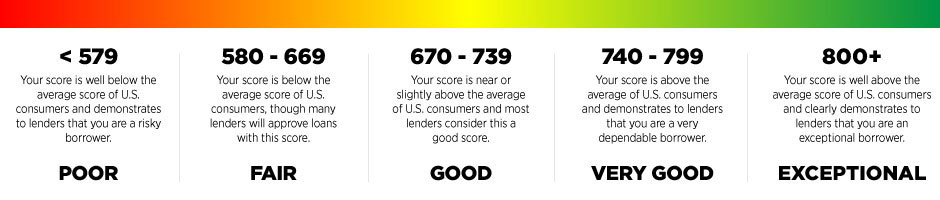

In [65]:
df['fico_rating'] = df.apply(lambda row: 'Poor' if row['fico_mean'] < 580
                                    else 'Fair' if row['fico_mean'] < 670
                                    else 'Good' if row['fico_mean'] < 740
                                    else 'Very Good' if row['fico_mean'] < 800
                                    else 'Exceptional', axis=1)

###W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

`fico_rating` vs `loan_status`

In [64]:
plot = go.Figure()

plot.add_trace(
    go.Violin(
        x=df['loan_status'][df['loan_status'] == 'Charged Off'],
        y=df['fico_mean'],
        box_visible=True,
        meanline_visible=True,
        line_color='red',
        name='Charged off'
        ))

plot.add_trace(
    go.Violin(
        x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
        y=df['fico_mean'],
        box_visible=True,
        meanline_visible=True,
        line_color='green',
        name='Fully Paid'
        ))

plot.update_layout(violinmode='group',title="Zależność spłacalności pożyczki od punktów FICO",
                  xaxis_title="loan_status",
                  yaxis_title="fico_mean",
                  template='plotly_dark',
                  violingroupgap=0.1
                  )

plot.show()

In [57]:
px.violin(df, y='fico_mean', color='loan_status', violinmode='overlay', title="Zależność spłacalności pożyczki od punktów FICO",
                template="plotly_dark", color_discrete_map={'Fully Paid': 'green', 'Charged Off': 'red'})

In [67]:
def chargedOffToPaidRatio(dataset, column):
    plot_data = dataset.groupby([column,'loan_status']).size().unstack().fillna(0)
    percentages = plot_data.div(plot_data.sum(axis=1), axis=0) * 100
    return percentages

chargedOffToPaidRatio(df, "fico_rating")

loan_status,Charged Off,Fully Paid
fico_rating,,
Exceptional,5.448718,94.551282
Fair,24.473549,75.526451
Good,15.955040,84.044960
Very Good,8.445581,91.554419


WNIOSKI:

Na podstawie przedstawionych wykresów wnioskuję, iż więcej pożyczek jest spłaconych
przez pożyczkobiorców z wyższym Fico

### W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO

`earliest_cr_line` vs `loan_status`